# Filtering our set of final tags

In [37]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools
from collections import Counter

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile
import collections

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions to view image

In [2]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [3]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [4]:
def si(idx):
    chk = idx/5000
    i = idx % 5000
    plt.imshow(to_rgb(image_hdf5['Chunk{}'.format(chk)][i][:,:,0]), cmap=mpl.cm.gray) 

# Process tags by frequency and spelling

## Spell checking stems

In [538]:
fn = "/data/nearest_neighbor_tagging/tags/architecture_top20.pkl"
tags = pickle.load(open(fn, 'r'))
print len(tags.keys())
tags[tags.keys()[0]]

104519


[(u'place', 12, ['placing', 'places']),
 (u'premier', 12, ['premieres', 'premiers', 'premiere']),
 (u'san', 8, ['sans']),
 (u'present', 8, ['presenter', 'presentation', 'presentment']),
 (u'church', 8, ['churches']),
 (u'grand', 8, ['grands']),
 (u'sous', 7),
 (u'long', 7),
 (u'part', 7),
 (u'edific', 6, ['edifices', 'edifice']),
 (u'princip', 6, ['principal']),
 (u'land', 6, ['lands']),
 (u'natur', 6, ['nature', 'natural', 'natures']),
 (u'fade', 5, ['fades']),
 (u'tradit', 5, ['traditions', 'tradition']),
 (u'servic', 5, ['services', 'service']),
 (u'lieu', 5),
 (u'extrem', 5, ['extremity', 'extremes', "extremity's", 'extreme']),
 (u'religi', 5, ["religious's", 'religious']),
 (u'main', 5, ['mains', 'mainly'])]

In [539]:
import enchant
import difflib
br = enchant.Dict("en_GB")
en = enchant.Dict("en_US")

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [540]:
stems_to_words = collections.defaultdict(lambda: set())
stems_to_word_keys = set()
for img in tags:
    for word_tuple in tags[img]:
        stems_to_word_keys.add(word_tuple[0])
        if len(word_tuple) == 3:  # suggestions
            stems_to_words[word_tuple[0]].update(word_tuple[-1])           

len(stems_to_word_keys)

6811

In [541]:
old_to_new_stem = {}

stem_in = 0
no_unstemmed_good = 0
no_unstemmed_bad = 0
unstemmed_good = 0
stem_unstem_sugg = 0
space = 0
other = 0
ctr = 0
question = 0

for stem in stems_to_word_keys:
    ctr += 1
    stem_old = stem
    
    # replace space with a hyphen to make it more searchable
    if ' ' in stem:
        stem = stem.replace(' ', '-')
        #print stem_old, stem
        
    # if stem in dictionary, use the stem because it's short and is a word
    if br.check(stem): 
        old_to_new_stem[stem_old] = stem  
        stem_in += 1
        #print stem
        
    # there are no unstemmed words from the OCR
    elif len(stems_to_words[stem]) == 0: 
        new_word = br.suggest(stem)[0].lower()
        new_score = enchant.utils.levenshtein(stem, new_word)
        
        if new_score <= 3: 
            old_to_new_stem[stem_old] = new_word
            #print stem, new_word
            no_unstemmed_good += 1

        else: 
            old_to_new_stem[stem_old] = ""  # throw away
            no_unstemmed_bad += 1

    # there are unstemmed words from the OCR
    else: 
        # unstem is the shortest word in the list of original words
        unstem = min(stems_to_words[stem], key=len)
        
        # unstem is in the dictionary
        if br.check(unstem): 
            old_to_new_stem[stem_old] = unstem
            unstemmed_good += 1
            continue
            
        # unstem and stem are both not in the dictionary
        # remove punctuation since this seems to help
        stem_nopunct = stem.replace('-', '').replace('\'', '')
        unstem_nopunct = unstem.replace('-', '').replace('\'', '')

        # get suggestion
        stem_suggs = br.suggest(stem_nopunct)
        unstem_suggs = br.suggest(unstem_nopunct)
        if len(stem_suggs) == 0 or len(unstem_suggs) == 0: 
            old_to_new_stem[stem_old] = ""
            continue

        stem_sugg = stem_suggs[0].lower()
        unstem_sugg = unstem_suggs[0].lower()

        # take the suggestion, since stem and unstem agree on the suggestion
        if stem_sugg == unstem_sugg: 
            old_to_new_stem[stem_old] = stem_sugg  
            stem_unstem_sugg  += 1
            continue

        # if stem agrees with its suggestion, take that; then if unstem agrees with its suggestion, take that
        if stem == stem_sugg: 
            old_to_new_stem[stem_old] = stem_sugg
            #print stem_sugg
        elif unstem == unstem_sugg: 
            old_to_new_stem[stem_old] = unstem_sugg
            #print unstem_sugg

        # both stem and unstem don't agree with their suggestions
        else:   
            stem_score = enchant.utils.levenshtein(stem, stem_sugg)
            unstem_score = enchant.utils.levenshtein(unstem, unstem_sugg)

            # take whichever suggestion is closest to its original
            if stem_score < unstem_score:
                old_to_new_stem[stem_old] = stem_sugg
            elif stem_score > unstem_score:
                old_to_new_stem[stem_old] = unstem_sugg

            # if distances are equal, how do we break ties
            else:
                if en.check(stem_nopunct): 
                    # print stem, stem_sugg, stem_score, unstem, unstem_sugg, unstem_score
                    # print stem_sugg
                    if stem_nopunct == stem_sugg.replace('-', '').replace('\'', ''): 
                        old_to_new_stem[stem_old] = stem_nopunct
                    else: old_to_new_stem[stem_old] = stem_old
                elif en.check(stem_old): old_to_new_stem[stem_old] = stem_old                            
                elif en.check(unstem): old_to_new_stem[stem_old] = unstem
                else: old_to_new_stem[stem_old] = stem_sugg
            
# throw away words less than 3 characters in length
for stem in old_to_new_stem:
    if len(old_to_new_stem[stem]) < 3: 
        old_to_new_stem[stem] = ""
        
print ctr, space, stem_in, no_unstemmed_good, no_unstemmed_bad, unstemmed_good, stem_unstem_sugg, other, question

6811 0 3416 1062 26 1372 224 0 0


## Replace all tags with these new stems

In [542]:
new_tags = {}
for img in tags:
    new_tags[img] = []
    for word_tup in tags[img]:
        new_word = old_to_new_stem[word_tup[0]]
        if new_word == '': continue
        new_tags[img].append((str(new_word), word_tup[1]))

In [678]:
x = np.random.choice(new_tags.keys())
print new_tags[x]

[('present', 8), ('interest', 5), ('occasion', 5), ('ion', 5), ('monument', 5), ('hand', 4), ('taint', 4), ('form', 4), ('city', 4), ('koran', 4), ('gen', 4), ('tour', 4), ('side', 4), ('public', 4), ('christian', 4), ('good', 4), ('principe', 4), ('long', 4), ('great', 4), ('land', 4)]


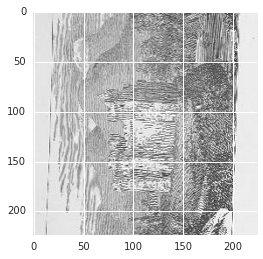

In [677]:
si(x)

## Words to picture mappings

In [713]:
words_to_img = collections.defaultdict(lambda: [])
for img in new_tags:
    for word_tup in new_tags[img]:
        words_to_img[word_tup[0]].append(img)
        
a = words_to_img.keys()
for key in a:
    if len(words_to_img[key]) > 40: 
        print key

lord
deli
dell
scholar
wooden
charter
millet
elegant
second
chine
china
herr
i'd
military
golden
stern
unit
music
telegraph
capital
holy
glass
maximilian
example
hog
auger
travel
machine
turk
beauty
eland
wine
township
silver
prize
bartok
cathedral
mdt
foundation
strata
purpose
nigel
instruct
service
master
gilbert
geneva
trek
tree
person
object
letter
professor
camp
prig
busy
rich
plate
agni
traverse
fair
result
bess
best
lott
xvi
glasgow
nature
souvenir
extent
veer
country
alcuin
erst
brindle
rend
union
privilege
fry
life
eastern
lift
child
commerce
kennan
castro
employ
viii
european
i'm
tune
birmingham
previous
han
prison
east
hat
right
people
crown
memorable
son
fabric
avail
happy
leiden
verde
liberal
exist
floor
republic
intent
time
chair
hole
vet
leave
burch
melt
ground
honour
benson
virtue
winter
grosser
edinburgh
date
dove
mange
kong
course
magog
nation
revers
quarter
square
siege
flanders
spanish
vote
open
city
boulevard
convent
savant
note
opposite
theiler
average
merit
brigh

In [787]:
print words_to_img["column"]

[526832, 44184, 265242, 918171, 219125, 528428, 531736, 875230, 533703, 273750, 307864, 275722, 277784, 278852, 279543, 279861, 658846, 808049, 284169, 25066, 25932, 550748, 26468, 26634, 813950, 814573, 814886, 28567, 28746, 293371, 31820, 293983, 293993, 295132, 34872, 299122, 38401, 43753, 44989, 307596, 45677, 832369, 308210, 570568, 51411, 46900, 834776, 219885, 50558, 51119, 51132, 575474, 51417, 51558, 51603, 51616, 52001, 52067, 52154, 883405, 840369, 842288, 580235, 318099, 580721, 319582, 57957, 320177, 582861, 58904, 577911, 585425, 63089, 709679, 852186, 68332, 856293, 595426, 858157, 71803, 334181, 335985, 336377, 599386, 76098, 338344, 601101, 76955, 78243, 865021, 865365, 319078, 866097, 674808, 606089, 82659, 869826, 325772, 85969, 86879, 873514, 614601, 877308, 878090, 616665, 355585, 356181, 277859, 356780, 621778, 884069, 623488, 623648, 625276, 890456, 106061, 107057, 631375, 895418, 109677, 373733, 936142, 900259, 376101, 901361, 119112, 648067, 911644, 912145, 912

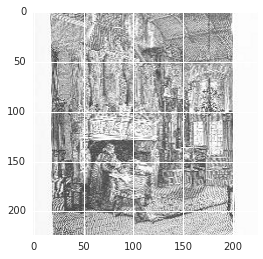

In [803]:
si(526832)

## Only keep the most common

In [302]:
all_stems = [tup[0] for key in new_tags for tup in new_tags[key]]
all_stems_ct = Counter(all_stems)
len(all_stems_ct.keys())

all_stems_ct.most_common()

[('great', 152570),
 ('good', 100487),
 ('time', 98368),
 ('long', 68374),
 ('large', 63346),
 ('hand', 52494),
 ('part', 51604),
 ('year', 50947),
 ('john', 47518),
 ('london', 46357),
 ('franc', 46212),
 ('place', 45695),
 ('england', 44765),
 ('young', 41053),
 ('present', 40490),
 ('office', 39782),
 ('history', 39128),
 ('small', 39061),
 ('land', 37877),
 ('house', 37461),
 ('grand', 35156),
 ('general', 33988),
 ('whole', 33592),
 ('nation', 32552),
 ('friend', 32294),
 ('life', 32061),
 ('ion', 29090),
 ('nature', 28160),
 ('work', 28137),
 ('english', 27967),
 ('public', 27808),
 ('william', 26086),
 ('force', 25331),
 ('chapter', 24202),
 ('name', 23786),
 ('premier', 23410),
 ('country', 23353),
 ('beauty', 22693),
 ('king', 21922),
 ('poor', 21780),
 ('fort', 21732),
 ('thing', 21255),
 ('', 19748),
 ('interest', 19739),
 ('george', 18655),
 ('side', 18505),
 ('white', 18389),
 ('lady', 18284),
 ('high', 17432),
 ('main', 17247),
 ('point', 16873),
 ('state', 16583),
 ('sch